# COVID-19 Forcasting (ft. LSTM)

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import tensorflow as tf
import warnings

warnings.filterwarnings(action='ignore')

## Data load

In [ ]:
train_df = pd.read_csv('./train.csv') # historical data 
test_df = pd.read_csv('./test.csv') # predictions to be filled

## Check missing value

In [9]:
train_df = train_df.fillna({'Province_State': 'Unknown'})
test_df = test_df.fillna({'Province_State': 'Unknown'})
train_df['Country_Region']= train_df['Country_Region'].str.replace("'", "")
train_df['Province_State']= train_df['Province_State'].str.replace("'", "")
test_df['Country_Region']= test_df['Country_Region'].str.replace("'", "")
test_df['Province_State']= test_df['Province_State'].str.replace("'", "")

train_df.isna().sum()

Id                0
Province_State    0
Country_Region    0
Date              0
ConfirmedCases    0
Fatalities        0
dtype: int64

In [10]:
def to_datetime(dt):
    return datetime.datetime.strptime(dt, '%Y-%m-%d')

def count_days(dt):
    return (dt - datetime.datetime.strptime('2020-01-22', "%Y-%m-%d")).days

train_df['Date_dt'] = train_df['Date'].map(to_datetime)
train_df['Day'] = train_df['Date_dt'].map(count_days)
test_df['Date_dt'] = test_df['Date'].map(to_datetime)
test_df['Day'] = test_df['Date_dt'].map(count_days)

## Scaling and Encoding

In [11]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Min-Max Scaler
scaler_c = MinMaxScaler(feature_range=(0, 100))
train_df['ConfirmedCases_scaled'] = None
train_df[['ConfirmedCases_scaled']] = scaler_c.fit_transform(train_df[['ConfirmedCases']])

scaler_f = MinMaxScaler(feature_range=(0, 100))
train_df['Fatalities_scaled'] = None
train_df[['Fatalities_scaled']] = scaler_f.fit_transform(train_df[['Fatalities']])

# Get dummy columns for geo location
geo_columns = []
n_geo_columns = 306
for i in range(n_geo_columns):
    geo_columns.append('Geo_{}'.format(i))
train_df.drop(columns=geo_columns, inplace=True, errors='ignore')

lbl_encoder = LabelEncoder()
scaler_g = MinMaxScaler(feature_range=(0, 1))
hot_encoder = OneHotEncoder(sparse=False)
train_df['Geo'] = train_df['Country_Region'].astype(str) + '_' + train_df['Province_State'].astype(str)
train_df[['Geo']] = lbl_encoder.fit_transform(train_df[['Geo']])
train_df = pd.get_dummies(train_df, prefix_sep="_", columns=['Geo'])


print(train_df.columns)
train_df[['ConfirmedCases', 'ConfirmedCases_scaled', 'Fatalities', 'Fatalities_scaled',  'Geo_0']].head()    

Index(['Id', 'Province_State', 'Country_Region', 'Date', 'ConfirmedCases',
       'Fatalities', 'Date_dt', 'Day', 'ConfirmedCases_scaled',
       'Fatalities_scaled',
       ...
       'Geo_296', 'Geo_297', 'Geo_298', 'Geo_299', 'Geo_300', 'Geo_301',
       'Geo_302', 'Geo_303', 'Geo_304', 'Geo_305'],
      dtype='object', length=316)


,ConfirmedCases,ConfirmedCases_scaled,Fatalities,Fatalities_scaled,Geo_0
0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,1


In [12]:
historical_steps = 14
n_output_node = 1

def make_sequential_input(df):
    
    inputs_c, inputs_f, inputs_geo, targets_c, targets_f = [], [], [], [], []
    
    for i in range(len(df) - historical_steps - 1):
        
        if df.iloc[i]['Country_Region'] == df.iloc[i + historical_steps]['Country_Region'] and \
            df.iloc[i]['Province_State'] == df.iloc[i + historical_steps]['Province_State']:
            
            # iloc[a:b] startnig from index 'a' and ending before b
            inputs_c.append(np.array(df.iloc[i : i + historical_steps][['ConfirmedCases_scaled']]).tolist()) # time seires until t-1
            inputs_f.append(np.array(df.iloc[i : i + historical_steps][['Fatalities_scaled']]).tolist()) # time seires until t-1
            inputs_geo.append(np.array(df.iloc[i + historical_steps][geo_columns]).tolist())
            targets_c.append(np.array(df.iloc[i + historical_steps][['ConfirmedCases_scaled']]).tolist()) # result data at time t
            targets_f.append(np.array(df.iloc[i + historical_steps][['Fatalities_scaled']]).tolist()) # result data at time t        
              
    return inputs_c, inputs_f, inputs_geo, targets_c, targets_f

# Make sequential input for training and validation
train_inputs, train_inputs_f, train_inputs_geo, train_targets_c, train_targets_f = make_sequential_input(train_df)

print('Train input shape: {}'.format(np.shape(train_inputs)))
print('Train input geo shape: {}'.format(np.shape(train_inputs_geo)))

Train input shape: (19277, 14, 1)
Train input geo shape: (19277, 306)


## Split train and val inputs

In [2]:
import random

max_index = np.array(train_inputs).shape[0] - 1
indices = []

for i in range(int(max_index*0.2)):
    indices.append(random.randint(0, max_index))

val_inputs = [ train_inputs[i] for i in indices ]
val_inputs_f = [ train_inputs_f[i] for i in indices ]
val_inputs_geo = [ train_inputs_geo[i] for i in indices  ] 
val_targets_c = [ train_targets_c[i] for i in indices ]
val_targets_f = [ train_targets_f[i] for i in indices ]

train_inputs = [ elem for i, elem in enumerate(train_inputs) if i not in indices ] 
train_inputs_f = [ elem for i, elem in enumerate(train_inputs_f) if i not in indices ] 
train_inputs_geo = [ elem for i, elem in enumerate(train_inputs_geo) if i not in indices ] 
train_targets_c = [ elem for i, elem in enumerate(train_targets_c) if i not in indices ] 
train_targets_f = [ elem for i, elem in enumerate(train_targets_f) if i not in indices ] 

pd.set_option('display.max_colwidth', -1) 
print('No. train data: {}'.format(len(train_inputs)))
print('No. validation data: {}'.format(len(val_inputs)))

## Tensorflow

Epoch 1/100
124/124 [==============================] - 11s 65ms/step - loss: 0.0129 - mean_absolute_error: 0.2996 - mean_squared_error: 10.1955 - val_loss: 0.0038 - val_mean_absolute_error: 0.2021 - val_mean_squared_error: 4.9046
Epoch 2/100
124/124 [==============================] - 8s 62ms/step - loss: 0.0031 - mean_absolute_error: 0.1919 - mean_squared_error: 5.7953 - val_loss: 0.0024 - val_mean_absolute_error: 0.1436 - val_mean_squared_error: 3.0584
Epoch 3/100
124/124 [==============================] - 8s 61ms/step - loss: 0.0020 - mean_absolute_error: 0.1556 - mean_squared_error: 4.1399 - val_loss: 0.0016 - val_mean_absolute_error: 0.1170 - val_mean_squared_error: 2.2153
Epoch 4/100
124/124 [==============================] - 8s 65ms/step - loss: 0.0016 - mean_absolute_error: 0.1341 - mean_squared_error: 3.2192 - val_loss: 9.0080e-04 - val_mean_absolute_error: 0.0887 - val_mean_squared_error: 1.6673
Epoch 5/100
124/124 [==============================] - 8s 67ms/step - loss: 0.0012

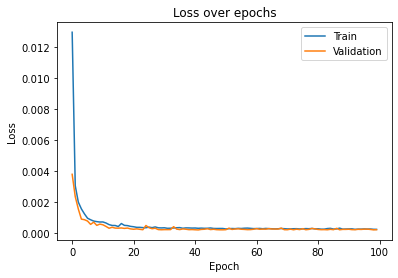

Epoch 1/100
124/124 [==============================] - 10s 63ms/step - loss: 0.0079 - mean_absolute_error: 0.1338 - mean_squared_error: 4.7033 - val_loss: 0.0017 - val_mean_absolute_error: 0.0646 - val_mean_squared_error: 1.2313
Epoch 2/100
124/124 [==============================] - 7s 57ms/step - loss: 0.0019 - mean_absolute_error: 0.0928 - mean_squared_error: 3.1768 - val_loss: 0.0015 - val_mean_absolute_error: 0.0637 - val_mean_squared_error: 1.0220
Epoch 3/100
124/124 [==============================] - 7s 58ms/step - loss: 0.0016 - mean_absolute_error: 0.0845 - mean_squared_error: 2.7810 - val_loss: 6.2146e-04 - val_mean_absolute_error: 0.0418 - val_mean_squared_error: 0.7580
Epoch 4/100
124/124 [==============================] - 7s 59ms/step - loss: 0.0010 - mean_absolute_error: 0.0690 - mean_squared_error: 2.2279 - val_loss: 5.5531e-04 - val_mean_absolute_error: 0.0382 - val_mean_squared_error: 0.5778
Epoch 5/100
124/124 [==============================] - 8s 63ms/step - loss: 8.8

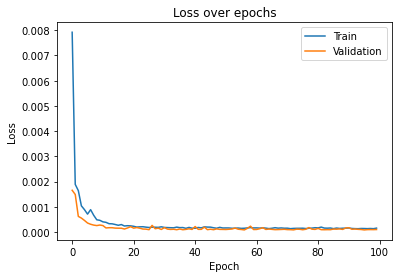

In [14]:
from tensorflow.keras import Model, Sequential, backend as K
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Dropout

n_output_node = 1
input_shape=np.array(train_inputs).shape[-2:]
input_shape_geo=np.array(train_inputs_geo).shape

batch_size = 128
epochs = 100
lr = 0.001

def create_model(model_type_name, load_weight, inputs=None, inputs_geo=None, targets=None, v_inputs=None, v_inputs_geo=None, v_targets=None):
    
    geo_input = Input(shape=(n_geo_columns,), name='input_geo')
    
    h_state = Dense(256)(geo_input)
    h_state = Dropout(0.1)(h_state)
    h_state = Dense(256, activation='relu')(h_state)
    c_state = Dense(256)(geo_input)
    c_state = Dropout(0.1)(c_state)
    c_state = Dense(256, activation='relu')(c_state)

    ts_input = Input(shape=input_shape, name='input_ts')
    lstm = LSTM(256, return_sequences=True)(ts_input, initial_state=[ h_state, c_state ])
    lstm = Dropout(0.1)(lstm)
    lstm = Bidirectional(LSTM(128))(lstm)
    lstm = Dropout(0.1)(lstm)
    main_output = Dense(n_output_node, activation='relu', name='output_main')(lstm)
    
    model = Model(inputs=[ geo_input, ts_input ], outputs=main_output)    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=tf.keras.losses.MSLE, metrics=[ tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanSquaredError() ])
    
    model_path = 'model_{}.h5'.format(model_type_name)
    
    if load_weight:
        
        model = tf.keras.models.load_model(model_path)
    else:
    
        history = model.fit([ inputs_geo, inputs ],  targets, \
                    epochs=epochs, \
                    batch_size=batch_size, \
                    verbose=1, \
                    validation_data=({ 'input_geo': v_inputs_geo, 'input_ts': v_inputs },{ 'output_main': v_targets}))

        scores = model.evaluate({ 'input_geo': inputs_geo, 'input_ts': inputs }, targets)
        print("Model Accuracy: {}".format(scores))
        
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Loss over epochs')
        plt.legend(['Train', 'Validation'], loc='best')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.show()
        
        model.save(model_path) 
        
    return model
                        

model_cases = create_model('case', False, np.array(train_inputs), np.array(train_inputs_geo), np.array(train_targets_c), np.array(val_inputs), np.array(val_inputs_geo), np.array(val_targets_c))
model_fatality = create_model('fatality', False, np.array(train_inputs_f), np.array(train_inputs_geo), np.array(train_targets_f), np.array(val_inputs_f), np.array(val_inputs_geo), np.array(val_targets_f))

In [15]:
def predict_cases(country, state):
    
    df = train_df[(train_df['Country_Region'] == country) & (train_df['Province_State'] == state) ]

    inputs = np.array(df[['ConfirmedCases_scaled']][-historical_steps-1:-1])
    inputs_geo = np.array(df.iloc[-1][geo_columns])
    actuals = np.array(df.iloc[-1][['ConfirmedCases']])
    
    predictions = model_cases.predict([  np.array(inputs_geo).astype(np.float32).reshape(1, len(geo_columns)), np.array(inputs).reshape(1, input_shape[0], input_shape[1]) ]).reshape(-1).tolist()
    
    print('Inputs: {}, Pred: {}, Expected: {}'.format( \
        np.array(df[['ConfirmedCases']][-historical_steps-1:-1])[:,0].tolist(), \
        scaler_c.inverse_transform(np.array(predictions).reshape(-1,1)), \
        actuals))
    
def predict_fatality(country, state):
    
    df = train_df[(train_df['Country_Region'] == country) & (train_df['Province_State'] == state) ]

    inputs = np.array(df[['Fatalities_scaled']][-historical_steps-1:-1])
    inputs_geo = np.array(df.iloc[-1][geo_columns])
    actuals = np.array(df.iloc[-1][['Fatalities']])
    
    predictions = model_fatality.predict([  np.array(inputs_geo).astype(np.float32).reshape(1, len(geo_columns)), np.array(inputs).reshape(1, input_shape[0], input_shape[1]) ]).reshape(-1).tolist()
    
    print('Inputs: {}, Pred: {}, Expected: {}'.format( \
        np.array(df[['Fatalities']][-historical_steps-1:-1])[:,0].tolist(), \
        scaler_f.inverse_transform(np.array(predictions).reshape(-1,1)), \
        actuals))
      

predict_cases('Australia', 'Victoria')
predict_cases('Australia', 'New South Wales')
predict_cases('Korea, South', 'Unknown')
predict_cases('Iran', 'Unknown')
predict_cases('Italy', 'Unknown')

predict_fatality('Australia', 'Victoria')
predict_fatality('Australia', 'New South Wales')
predict_fatality('Korea, South', 'Unknown')
predict_fatality('Iran', 'Unknown')
predict_fatality('Italy', 'Unknown')

Inputs: [411.0, 466.0, 520.0, 574.0, 685.0, 769.0, 821.0, 917.0, 968.0, 1036.0, 1085.0, 1115.0, 1135.0, 1158.0], Pred: [[1176.87049774]], Expected: [1191.0]
Inputs: [818.0, 1029.0, 1219.0, 1405.0, 1617.0, 1791.0, 2032.0, 2032.0, 2182.0, 2298.0, 2389.0, 2493.0, 2580.0, 2637.0], Pred: [[2677.17659875]], Expected: [2686.0]
Inputs: [9037.0, 9137.0, 9241.0, 9332.0, 9478.0, 9583.0, 9661.0, 9786.0, 9887.0, 9976.0, 10062.0, 10156.0, 10237.0, 10284.0], Pred: [[10478.43319056]], Expected: [10331.0]
Inputs: [24811.0, 27017.0, 29406.0, 32332.0, 35408.0, 38309.0, 41495.0, 44605.0, 47593.0, 50468.0, 53183.0, 55743.0, 58226.0, 60500.0], Pred: [[61791.04907845]], Expected: [62589.0]
Inputs: [69176.0, 74386.0, 80589.0, 86498.0, 92472.0, 97689.0, 101739.0, 105792.0, 110574.0, 115242.0, 119827.0, 124632.0, 128948.0, 132547.0], Pred: [[130673.26369217]], Expected: [135586.0]
Inputs: [0.0, 0.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 5.0, 7.0, 8.0, 8.0, 10.0], Pred: [[11.76921723]], Expected: [11.0]
Inputs: [7.

## Forecasting

In [17]:
import time

test_df['ConfirmedCases'] = None
test_df['Fatalities'] = None

temp_df = train_df.copy()
temp_df = pd.concat([ temp_df, test_df[test_df.Day > train_df.iloc[-1].Day] ], ignore_index=True)
temp_df['ConfirmedCases_scaled_predicted'] = None
temp_df['Fatalities_scaled_predicted'] = None

day_predicting_from = 64
day_predicting_to = 106

current_row = None
hist_rows = None

tic = time.perf_counter()
counter = 0

# For each country and state
# for c, s in test_df[(test_df.Country_Region=='Australia') & (test_df.Province_State=='New South Wales')].groupby(['Country_Region', 'Province_State']): 
# for c, s in test_df[(test_df.Country_Region=='Australia') & (test_df.Province_State=='Victoria')].groupby(['Country_Region', 'Province_State']): 
# for c, s in test_df[(test_df.Country_Region=='Korea, South') & (test_df.Province_State=='Unknown')].groupby(['Country_Region', 'Province_State']):  
# for c, s in test_df[(test_df.Country_Region=='Italy') & (test_df.Province_State=='Unknown')].groupby(['Country_Region', 'Province_State']):  
# for c, s in test_df[(test_df.Country_Region=='France') & (test_df.Province_State=='Unknown')].groupby(['Country_Region', 'Province_State']): 
# for c, s in test_df[(test_df.Country_Region=='China') & (test_df.Province_State=='Hubei')].groupby(['Country_Region', 'Province_State']):  
for c, s in test_df.groupby(['Country_Region', 'Province_State']):  
    
    toc = time.perf_counter()
    
    country = c[0]
    state = c[1]
    
    # Traverse from Day 64 to the end
    for day in range(day_predicting_from, day_predicting_to + 1):   
        current_row = temp_df[ (temp_df.Country_Region == country) & (temp_df.Province_State == state) & (temp_df.Day == day)]
        hist_rows = temp_df[(temp_df.Country_Region == country) & (temp_df.Province_State == state) & (temp_df.Day >= (day - historical_steps)) & (temp_df.Day < day)]
        
        # Only predict when historical steps exist
        if not current_row.empty and not hist_rows.empty and hist_rows.shape[0] == historical_steps:    
            input_geo = np.array(hist_rows.iloc[-historical_steps][geo_columns]).reshape(1, len(geo_columns))
            input_c = np.array(hist_rows.iloc[-historical_steps:,][['ConfirmedCases_scaled']]).reshape(1, input_shape[0], input_shape[1])
            input_f = np.array(hist_rows.iloc[-historical_steps:,][['Fatalities_scaled']]).reshape(1, input_shape[0], input_shape[1])
            pred = model_cases.predict([ tf.convert_to_tensor(input_geo, np.float64), tf.convert_to_tensor(input_c, np.float64) ])
            pred_f = model_fatality.predict([ tf.convert_to_tensor(input_geo, np.float64), tf.convert_to_tensor(input_f, np.float64) ])
  
            # Update the predict fields
            current_idx = current_row.index.values[0]
            temp_df.at[current_idx, 'ConfirmedCases_scaled_predicted'] = float(pred[0][0])
            temp_df.at[current_idx, 'Fatalities_scaled_predicted'] = float(pred_f[0][0])
            
            last = hist_rows.iloc[-1,]
            for col_name in geo_columns:
                temp_df.at[current_idx, col_name] = last[col_name]
            
            # Update the existing fields if empty
            if (current_row['ConfirmedCases'].values[0] == None) and (current_row['Fatalities'].values[0] == None):
                temp_df.at[current_idx, 'ConfirmedCases_scaled'] = float(pred[0][0])
                temp_df.at[current_idx, 'Fatalities_scaled'] = float(pred_f[0][0])
    
    toc = time.perf_counter()
    counter = counter + 1
    print('{:.2f} sec(s) taken - Geo: {},{}, Count: {}'.format((toc-tic), country, state, counter))
        

temp_df['ConfirmedCases_inversed_predicted'] = None
temp_df['Fatalities_inversed_predicted'] = None
temp_df[['ConfirmedCases_inversed_predicted']] = scaler_c.inverse_transform(temp_df[['ConfirmedCases_scaled_predicted']])
temp_df[['Fatalities_inversed_predicted']] = scaler_f.inverse_transform(temp_df[['Fatalities_scaled_predicted']]) 

3.14 sec(s) taken - Geo: Afghanistan,Unknown, Count: 1
6.20 sec(s) taken - Geo: Albania,Unknown, Count: 2
9.25 sec(s) taken - Geo: Algeria,Unknown, Count: 3
12.34 sec(s) taken - Geo: Andorra,Unknown, Count: 4
15.40 sec(s) taken - Geo: Angola,Unknown, Count: 5
18.45 sec(s) taken - Geo: Antigua and Barbuda,Unknown, Count: 6
21.50 sec(s) taken - Geo: Argentina,Unknown, Count: 7
24.54 sec(s) taken - Geo: Armenia,Unknown, Count: 8
27.64 sec(s) taken - Geo: Australia,Australian Capital Territory, Count: 9
30.74 sec(s) taken - Geo: Australia,New South Wales, Count: 10
33.89 sec(s) taken - Geo: Australia,Northern Territory, Count: 11
37.00 sec(s) taken - Geo: Australia,Queensland, Count: 12
40.11 sec(s) taken - Geo: Australia,South Australia, Count: 13
43.23 sec(s) taken - Geo: Australia,Tasmania, Count: 14
46.27 sec(s) taken - Geo: Australia,Victoria, Count: 15
49.31 sec(s) taken - Geo: Australia,Western Australia, Count: 16
52.40 sec(s) taken - Geo: Austria,Unknown, Count: 17
55.45 sec(s) ta

In [18]:
temp_df[(temp_df.Country_Region=='Australia') & (temp_df.Province_State=='New South Wales')] \
[['ForecastId', 'Day', 'Date', 'Country_Region', 'Province_State', 'ConfirmedCases', 'ConfirmedCases_scaled', 'ConfirmedCases_scaled_predicted', 'ConfirmedCases_inversed_predicted']] \
.iloc[-45:,:]

,ForecastId,Day,Date,Country_Region,Province_State,ConfirmedCases,ConfirmedCases_scaled,ConfirmedCases_scaled_predicted,ConfirmedCases_inversed_predicted
755,NaN,62,2020-03-24,Australia,New South Wales,818.0,0.576292,None,NaN
756,NaN,63,2020-03-25,Australia,New South Wales,1029.0,0.724944,None,NaN
757,NaN,64,2020-03-26,Australia,New South Wales,1219.0,0.858801,0.819314,1162.951274
758,NaN,65,2020-03-27,Australia,New South Wales,1405.0,0.989841,0.985796,1399.258015
759,NaN,66,2020-03-28,Australia,New South Wales,1617.0,1.139198,1.132756,1607.856176
760,NaN,67,2020-03-29,Australia,New South Wales,1791.0,1.261783,1.284205,1822.826204
761,NaN,68,2020-03-30,Australia,New South Wales,2032.0,1.431571,1.407752,1998.191227
762,NaN,69,2020-03-31,Australia,New South Wales,2032.0,1.431571,1.581246,2244.452054
763,NaN,70,2020-04-01,Australia,New South Wales,2182.0,1.537248,1.582963,2246.889496
764,NaN,71,2020-04-02,Australia,New South Wales,2298.0,1.618971,1.651253,2343.821343


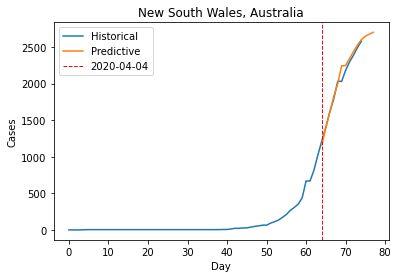

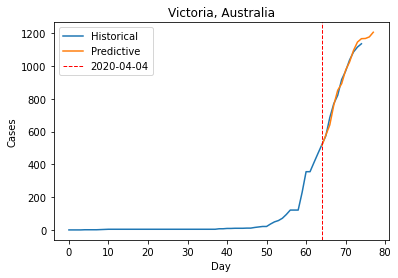

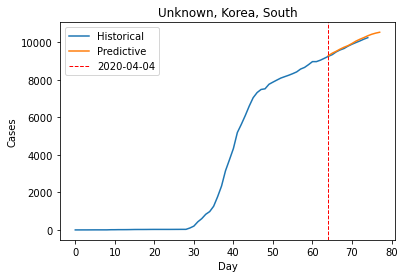

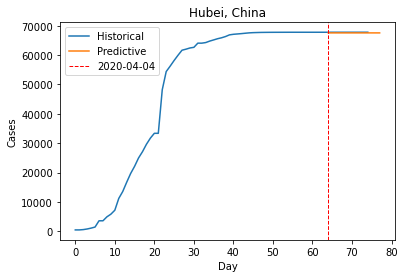

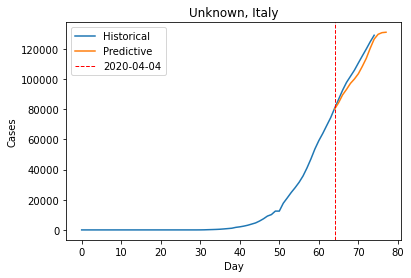

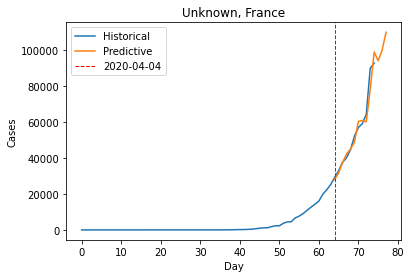

[None, None, None, None, None, None]

In [19]:
def plot_by_country(country, state):

    hist_df = temp_df[(temp_df.Country_Region == country) & (temp_df.Province_State == state) & (temp_df.Day <= 74)].groupby(['Country_Region', 'Province_State', 'Day', 'Date']).agg({'ConfirmedCases': 'first'}).reset_index()
    pred_df = temp_df[(temp_df.Country_Region == country) & (temp_df.Province_State == state) & (temp_df.Day >= 64)].groupby(['Country_Region', 'Province_State', 'Day', 'Date']).agg({'ConfirmedCases_inversed_predicted': 'first'}).reset_index()

    plt.title('{}, {}'.format(state, country))
    plt.plot(hist_df.Day, hist_df.ConfirmedCases, label='Historical')
    plt.plot(pred_df.Day, pred_df.ConfirmedCases_inversed_predicted, label='Predictive')
    plt.axvline(x=day_predicting_from, color='r', linestyle='--', linewidth=1, label='2020-04-04')
    plt.xlabel('Day')
    plt.ylabel('Cases')
    plt.legend()
    plt.show()
    
[ plot_by_country(country, state) for country, state in [ \
    ('Australia', 'New South Wales'), ('Australia', 'Victoria'), ('Korea, South', 'Unknown'), ('China', 'Hubei'), ('Italy', 'Unknown'), ('France', 'Unknown')]]

In [20]:
tic = time.perf_counter()

for i in range(len(test_df)):
    
    country = test_df.at[i, 'Country_Region']
    state = test_df.at[i, 'Province_State']
    day = test_df.at[i, 'Day']
    
    current_df = temp_df[(temp_df.Country_Region == country) & (temp_df.Province_State == state) & (temp_df.Day == day)]
    test_df.at[i, 'ConfirmedCases'] = current_df['ConfirmedCases_inversed_predicted'].values[0]
    test_df.at[i, 'Fatalities'] = current_df['Fatalities_inversed_predicted'].values[0]
    
    if i%1000 == 0:
        toc = time.perf_counter()
        print('{:.2f} sec(s) taken'.format((toc-tic)))

test_df[['ForecastId', 'ConfirmedCases', 'Fatalities']].to_csv('submission.csv', index=False)

0.00 sec(s) taken
3.22 sec(s) taken


KeyboardInterrupt: 